In [0]:
#header for accessing google drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive


E: Package 'python-software-properties' has no installation candidate
··········
fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


# **Detecting pneumonia in chest x-ray images with deep learning**

The goal of this project is to create a model able to distinguish between chest x-ray images corresponding to normal lungs and lungs with pneumonia. The dataset has been obtained from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia and the model will be a Convolutional Neural Network (CNN) classifier.

Since this is a classification problem, recall and precision metrics will be considered together with accuracy. These metrics can be monitored during training for both training and test data, which allows us to stop training when one of these metrics reaches an optimal value.






## Header

We will import all the dependencies needed: libraries to work with images and vectors, plotting tools, sklearn and keras

In [0]:
!pip install keras-metrics

from PIL import Image
import glob
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE
from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf
import keras
import keras_metrics as km
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier



## Inspection 

First of all we will count the number of images of each class in the data for training:

In [0]:
directory = '/content/drive/xray/train'
ld_nor = glob.glob(directory+'/NORMAL/*.jpeg')
ld_pne = glob.glob(directory+'/PNEUMONIA/*.jpeg')

print('Normal: {}'.format(len(ld_nor)))
print('Pneumonia: {}'.format(len(ld_pne)))

Normal: 1341
Pneumonia: 3875


There are more than twice images with pneumonia than normal, so the training data is imbalanced. We will handle this later by oversampling the minority class. 

Let's examine visually some of the images of each class

Text(0, 0.75, 'Normal')

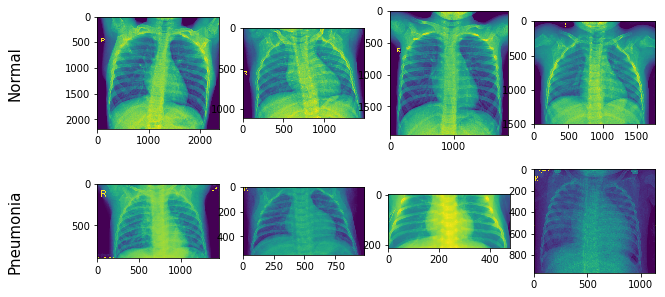

In [0]:
samples = random.sample(ld_nor,4) + random.sample(ld_pne,4)

fig, axes = plt.subplots(2, 4,figsize=(10,5))
for i in range(8):
  im = Image.open(samples[i]).convert(mode='L')
  axes[int(i/4),i%4].imshow(im)  
fig.text(0, 0.35, 'Pneumonia', fontsize=15,rotation=90)
fig.text(0, 0.75, 'Normal', fontsize=15,rotation=90)

We can see that distinguishing normal lungs from lungs with pneumonia is challenging for the untrained eye. Hopefully our algorithm won't need to go to medical school!



## Load dataset, resize and save tensors

The images are of variable size. For feeding the dataset to the model we need to reshape all the images to the same size.

Also the resolution of the images is relatively high. In order to avoid a huge computational burden for training the model it is convenient to low the resolution of the images, in this case 100 by 100 pixels. We will see that this resolution is more than enough for training our classifier.


The following function loads the images, reduces the size and saves the data into tensors. Loading a tensor is significantly faster than loading the entire dataset image by image.

In [0]:
def save_tensors(dat,N_size):

  print('Loading '+dat+' data')
  directory = '/content/drive/xray/'
  
  normal_X = []
  normal_y = []
  for filename in glob.glob(directory+dat+'/NORMAL/*.jpeg'):
      im = Image.open(filename)
      gs_im = im.convert(mode='L')
      rsz_im = gs_im.resize((N_size,N_size))

      normal_X.append(np.array(rsz_im))
      normal_y.append(0)
 
  print('NORMAL loaded')
  
  pne_X = []
  pne_y = []
  for filename in glob.glob(directory+dat+'/PNEUMONIA/*.jpeg'):
      im = Image.open(filename)
      gs_im = im.convert(mode='L')
      rsz_im = gs_im.resize((N_size,N_size))

      pne_X.append(np.array(rsz_im))
      pne_y.append(1)

  print('PNEUMONIA loaded')

  #data assembly
  normal_X = np.reshape(np.array(normal_X),(len(normal_X),N_size,N_size,1))
  normal_y = np.array(normal_y)

  pne_X = np.reshape(np.array(pne_X),(len(pne_X),N_size,N_size,1))
  pne_y = np.array(pne_y)

  #save tensors
  np.save(directory+dat+'/NORMAL/normal_X.npy',normal_X)
  np.save(directory+dat+'/NORMAL/normal_y.npy',normal_y)
  np.save(directory+dat+'/PNEUMONIA/pne_X.npy',pne_X)
  np.save(directory+dat+'/PNEUMONIA/pne_y.npy',pne_y)
  return

N_size = 100
save_tensors('train',N_size)
save_tensors('test',N_size)

## **Loading tensors**

The following function simply loads the tensors created before. 



In [0]:
def load_tensors(dat):

  directory = '/content/drive/xray/'

  normal_X = np.load(directory+str(dat)+'/NORMAL/normal_X.npy')
  normal_y = np.load(directory+str(dat)+'/NORMAL/normal_y.npy')
  pne_X = np.load(directory+str(dat)+'/PNEUMONIA/pne_X.npy')
  pne_y = np.load(directory+str(dat)+'/PNEUMONIA/pne_y.npy')
  
  X = np.concatenate((normal_X,pne_X),axis=0)
  y = np.concatenate((normal_y,pne_y),axis=0)

  return X, y

N_size = 100
X,y = load_tensors('train')
X_test,y_test = load_tensors('test')

## Oversampling


There are slightly more classes from pneunomia than from normal as we saw before. This might be a problem since the classifier might be 'overwhelmed' by the amount of samples from the majority class and won't have enough samples from the minority class, so the performance might be compromised.

In this case oversampling for the minority class (normal x-ray images) will be applied using [SMOTE](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html), which generates synthetic data from the minority class therefore balancing the dataset.





In [0]:
#oversampling the training data
X_train, y_train = SMOTE().fit_resample(np.reshape(X,(X.shape[0],N_size**2)), y)
X_train = np.reshape(X_train,(X_train.shape[0],N_size,N_size,1))
print('Dimensions of oversampled training data: ',X_train.shape)

Dimensions of oversampled training data:  (7750, 100, 100, 1)


The number of images in the dataset after oversampling is twice the number of instances of the majority class. Part of the normal x-ray images has been generated from the original normal x-ray images. 

Deep learning models appreciate the data being between 0 and 1. Since the maximum pixel intensity is 255 and we are working with grayscale images, it is enough to divide by 255:



In [0]:
#scaling
X_train,X_test = X_train/255.0, X_test/255.0

## Convolutional Neural Network

We will build our model as a Convolutional Neural Network using the sequential API of keras. The first layer is a convolutional layer together with max pooling for feature extraction. On top of it we set a dense layer as the classifier and a single binary output, being 0 for a normal image and 1 for pneumonia. 

Since this is a binary classification problem we will use binar crosssentropy as the loss function. Stochastic gradient descent with the given learning rate demonstrated to be a good choice in this case. We will also use L2 and dropout as regularization. 

Apart from the loss and accuracy, precision and recall will also be considered as metrics for training. In order to prevent overfitting early stopping will also be used. One of the metrics will be monitored and training will stop when the monitored metric reaches its maximum (or minimum) value.

In [0]:
def init_model(conv=64, dense = 32, l2 = 0.001, dpt = 0.25):

  model = Sequential()

  #convolutional layer
  model.add(Conv2D(conv, (3,3), input_shape=(N_size,N_size,1),kernel_regularizer=regularizers.l2(l2)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  #classifier
  model.add(Flatten())
  model.add(Dense(dense,kernel_regularizer=regularizers.l2(l2)))
  model.add(Activation('relu'))
  model.add(Dropout(dpt))
  model.add(Dense(1, activation='sigmoid'))

  #optimizer
  optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)

  #compile model
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', km.binary_precision(), km.binary_recall()])

  return model

def plot_history(ax,history,metric,title=''):
  ax.plot(history[metric],label = 'train')
  ax.plot(history['val_'+metric],label = 'test')
  ax.set_title(title)
  ax.set_ylabel(metric)
  ax.set_xlabel('epoch')
  ax.legend()

## Max accuracy



The goal of this section is to obtain the model with maximum accuracy, so we will monitor the test accuracy using early stopping. If the test accuracy does not improve after 5 epochs, the training is stopped and the best model is returned and saved.

In [0]:
es = EarlyStopping(monitor='val_acc', mode='max',patience = 5, verbose=0, restore_best_weights=True)
model = init_model()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),batch_size=32,epochs=50,callbacks=[es])
model.save("/content/drive/xray/best_acc.h5")

Once the model is trained, we can plot the loss and accuracy during training

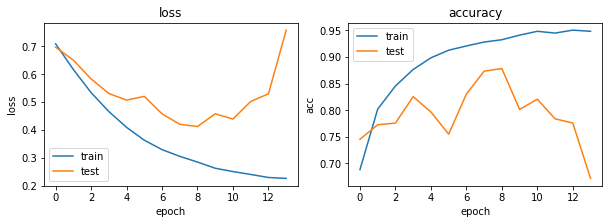

In [0]:
fig,ax = plt.subplots(1,2,figsize=(10,3))
plot_history(ax[0],history.history,'loss','loss')
plot_history(ax[1],history.history,'acc','accuracy')

The training loss (accuracy) decreases (increases) monotonically during training. The validation loss, however, increases after reaching the minimum. This is a clear sign of overfitting, and we see that the accuracy goes down as well at the end of training. 

The resulting model corresponds to the one with the highest accuracy in this case, and we can evaluate the precision and recall:

In [0]:
#predicted test data
y_pred = model.predict(X_test) >= 0.5
#metrics
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {}'.format(precision_score(y_test, y_pred)))
print('Recall: {}'.format(recall_score(y_test, y_pred)))

Accuracy: 0.8782051282051282
Precision:  0.8792270531400966
Recall:  0.9333333333333333


Not bad! The model with the highest accuracy also has good values for the precision and recall. 


Precision intuitively indicates how well the classifier identifies all the negative samples. In this case the negative samples are the normal x ray images. Therefore a classifier with good precision will have few false positives in test data. Recall can be interpreted as the opposite of precision, indicating how well the classifier is able to identify all the positive samples (pneumonia in this case). 

From a medical application point of view it is of special interest to have high recall so the classifier is able to identify as many pneumonia x-rays as possible.

A common way to visualize the performance of the classifier is with the confusion matrix, which contains the number of true positives and true negatives in the diagonal elements and false positives and negatives in the off diagonal elements.

For the model trained in this section the confusion matrix is given by:

<Figure size 432x288 with 0 Axes>

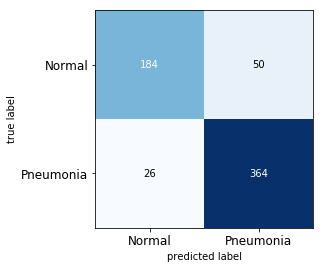

In [0]:
cm = confusion_matrix(y_test, y_pred)
#plot confusion matrix
plt.figure()
plot_confusion_matrix(cm,figsize=(8,4), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=12)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=12)
plt.show()

The number of false positives and negatives is significantly smaller than the number of true positives and negatives as expected. We also observe that the number of false negatives is smaller than the number of false positives since the recall is greater than the precision and the test set is balanced. 

## Max recall

In this section the recall will be monitored and the model will stop training when the recall doesn't improve after 5 epochs

In [0]:
es = EarlyStopping(monitor='val_recall', mode='max',patience = 5, verbose=0, restore_best_weights=True)
model = init_model()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),batch_size=32,epochs=50,callbacks=[es])
model.save("/content/drive/xray/best_recall.h5")

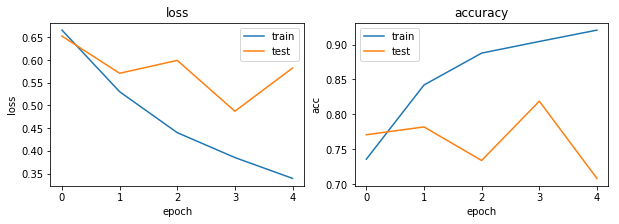

In [0]:
fig_loss,ax = plt.subplots(1,2,figsize=(10,3))
plot_history(ax[0],history.history,'loss','loss')
plot_history(ax[1],history.history,'acc','accuracy')

In [0]:
y_pred = model.predict(X_test) >= 0.5
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {}'.format(precision_score(y_test, y_pred)))
print('Recall: {}'.format(recall_score(y_test, y_pred)))

Accuracy:  0.7163461538461539
Precision:  0.6878306878306878
Recall:  1.0


The model with maximum recall has smaller accuracy and precision than the model in the previous section. The model got really good at identifying pneumonia images, although it also classifies a lot of normal images as pneumonia, having a large number of false positives.

This can be observed in the confusion matrix:

<Figure size 432x288 with 0 Axes>

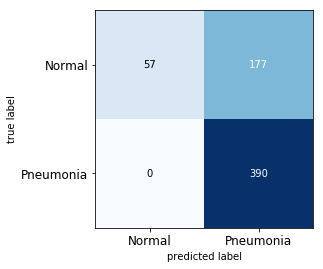

In [0]:
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cm,figsize=(8,4), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=12)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=12)
plt.show()

## **Hyperparameter optimization**

The previous results, although good, are for the particular configuration of hyperparameters chosen. It is expected that a different set of hyperparameters might yield even better results. We will use random search for finding the best performing hyperparameters. The parameters of interest are the size of the convolutional and dense layer, the penalty coefficient of the l2 regularization and the dropout rate.

The accuracy, recall and precision metrics will be stored in a pandas dataframe and saved as a CSV as well as the training histories.

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min',patience = 5, verbose=0, restore_best_weights=True)
param_grid = {'conv' : [32,64,128], 'dense' : [32,64,128], 'dpt':[0.0,0.1,0.2,0.3],'l2':[0.0,0.001,0.01,0.1]}
grid = ParameterSampler(param_grid,10)

path_metrics = '/content/drive/xray/metrics_hyperparameters.csv'
path_histories = '/content/drive/xray/histories_hyperparameters.csv'
metrics = pd.DataFrame()
histories = pd.DataFrame()

for params in grid:
  
  print('Parameters: ',params)

  #initialize classifier
  model = KerasClassifier(build_fn=init_model, verbose=0,
                      conv = params['conv'], dense=params['dense'],
                     dpt = params['dpt'],l2 = params['l2'])
  #training
  history = model.fit(X_train,y_train,validation_data=(X_test, y_test),
            verbose = 0,batch_size=32,epochs=100,callbacks=[es])

  #prediction test data
  y_pred = model.predict(X_test) >= 0.5
  acc_sc = accuracy_score(y_test,y_pred)
  recall_sc = recall_score(y_test,y_pred)
  precision_sc = precision_score(y_test,y_pred)
  
  #save metrics
  data = {str(params): [acc_sc, recall_sc, precision_sc]}
  res = pd.DataFrame.from_dict(data, orient='index',
                          columns=['accuracy', 'recall', 'precision'])
  metrics = metrics.append(res)
  metrics.to_csv(path_metrics,index_label=False)
  
  #save history
  data = {str(params): [history.history]}
  res = pd.DataFrame.from_dict(data, orient='index',
                          columns=['history'])
  
  histories = histories.append(res)
  histories.to_csv(path_histories,index_label=False)
  
  print('Accuracy: {}'.format(acc_sc))
  print('Recall: {}'.format(recall_sc))
  print('Precision: {}'.format(precision_sc))
  print('\n')

  


We can examine the metrics for the different combinations of hyperparameters:

In [0]:
pd.set_option('display.width', 1000)

path_metrics = '/content/drive/xray/metrics_hyperparameters.csv'
metrics = pd.read_csv(path_metrics)
for i in range(metrics.shape[0]):
  print(metrics.index[i])
  print('Accuracy: {}'.format(metrics['accuracy'].iloc[i]))
  print('Recall: {}'.format(metrics['recall'].iloc[i]))
  print('Precision: {}'.format(metrics['precision'].iloc[i]))
  print('\n')



{'l2': 0.01, 'dpt': 0.1, 'dense': 32, 'conv': 128}
Accuracy: 0.8766025641025641
Recall: 0.9128205128205128
Precision: 0.8922305764411027


{'l2': 0.1, 'dpt': 0.2, 'dense': 128, 'conv': 64}
Accuracy: 0.8541666666666666
Recall: 0.9307692307692308
Precision: 0.8501170960187353


{'l2': 0.01, 'dpt': 0.2, 'dense': 128, 'conv': 64}
Accuracy: 0.8621794871794872
Recall: 0.9230769230769232
Precision: 0.8653846153846154


{'l2': 0.1, 'dpt': 0.3, 'dense': 32, 'conv': 128}
Accuracy: 0.8637820512820513
Recall: 0.9102564102564102
Precision: 0.8765432098765432


{'l2': 0.1, 'dpt': 0.1, 'dense': 32, 'conv': 128}
Accuracy: 0.8541666666666666
Recall: 0.9384615384615383
Precision: 0.8452655889145496


{'l2': 0.001, 'dpt': 0.1, 'dense': 128, 'conv': 32}
Accuracy: 0.8733974358974359
Recall: 0.9153846153846154
Precision: 0.8858560794044665


{'l2': 0.01, 'dpt': 0.1, 'dense': 64, 'conv': 64}
Accuracy: 0.8381410256410257
Recall: 0.953846153846154
Precision: 0.8175824175824176


{'l2': 0.001, 'dpt': 0.2, 'dens

Apart from the accuracy, recall and precision scores, it is also interesting to plot the training histories of the previous experiment:

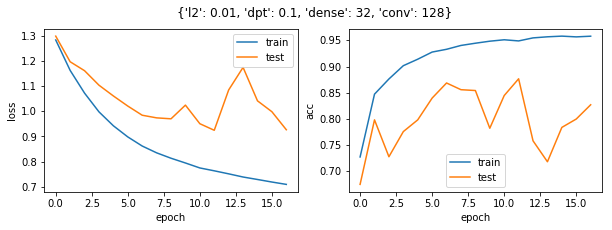

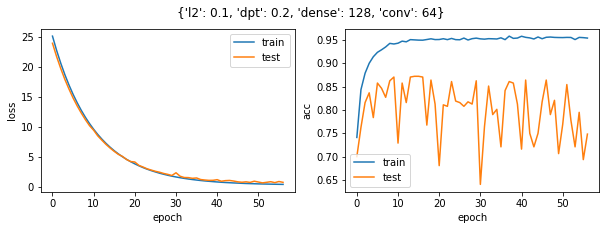

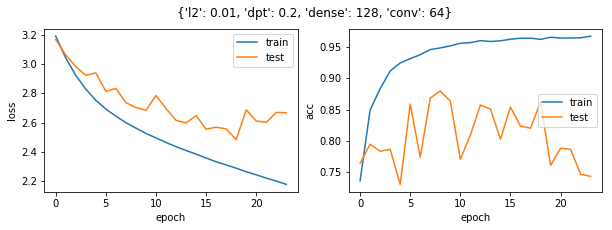

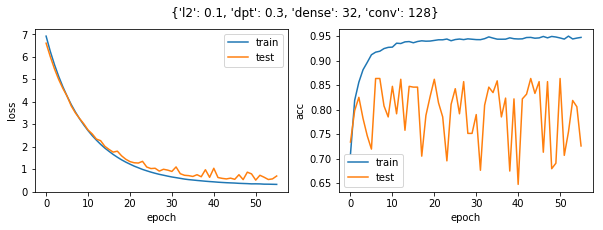

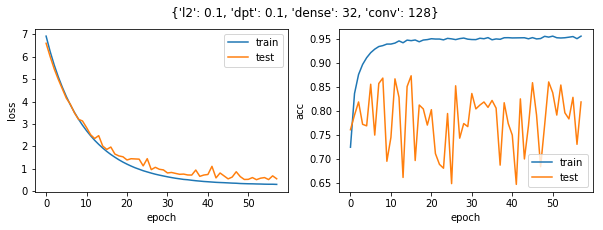

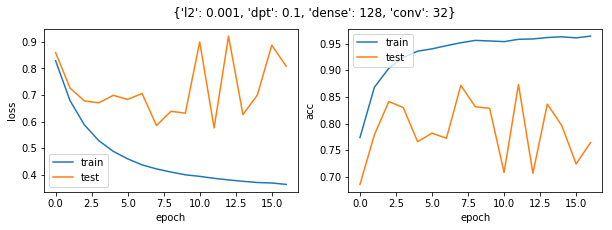

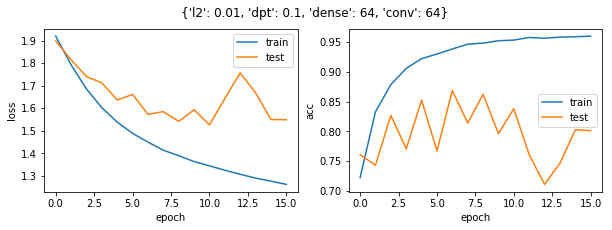

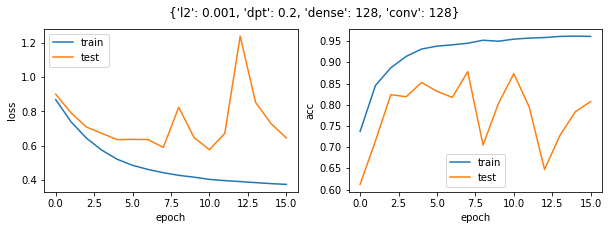

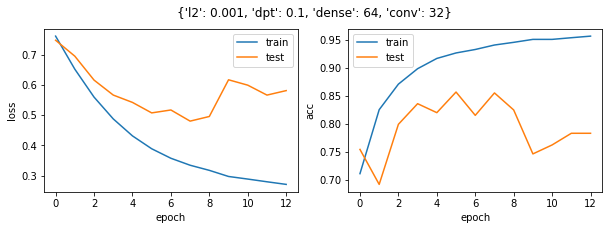

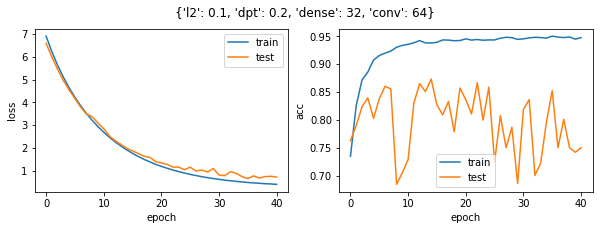

In [0]:
path_histories = '/content/drive/xray/histories_hyperparameters.csv'
histories = pd.read_csv(path_histories)
for i in range(histories.shape[0]):
  fig, ax = plt.subplots(1, 2, figsize=(10,3))
  fig.suptitle(histories.index[i])
  history = eval(histories['history'].iloc[i])
  plot_history(ax[0],history,'loss')
  plot_history(ax[1],history,'acc')

From the training histories above it can be observed that large values for the l2 regularization coefficient yield more stable learning than for small values of the l2 penalty coefficient. Although the test accuracy present oscillations, the number of training epochs is significantly larger than for small values of the l2 coefficient.